# <center>Prepare Lab of 2nd Exercise</center>

## <center> Speech Recognition using HMMs and RNNs </center>

### Description

Our goal is the implementation of a speech recognition system, that recognizes isolated words. The first part involves the extraction of the appropriate acoustic features from our recordings and their further analysis. These features are the cepstral coefficients, that are computed using a filterbank (inspired by psychoacoustic methods).

More specifically, the system will recognize isolated digits in English. Our dataset contains dictations of 9 digits from 15 different speakers in separate .wav files. In total, there are 133 files, since 2 dictations are missing. The name of each file (e.g. eight8.wav) declares both the dictated digit (e.g. eight) and the speaker (speakers are numbered from 1 to 15). The sampling rate is Fs=16k and the duration of each dictation differs.

### Implementation

Import necessary libraries

In [1]:
import librosa as l
import os
import re
import IPython.display as ipd
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# pytorch
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
from torch import optim

# pandas
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

__Step 1:__ Sound analysis using [Praat](http://www.fon.hum.uva.nl/praat/). 

- Open __onetwothree1.wav__ and __onetwothree8.wav__ using Praat. These files contain the phrase "one two three" from speakers 1 and 8 (male and female respectively).

- Waveforms of male and female speaker


<img src="outputs/waveform.png" alt="Waveforms" style="width: 700px;height: 700px;"/>


- Spectogram of male speaker

<img src="outputs/spec_male.png" alt="Male specrogram" style="width: 700px; height: 700px;"/>

Spectogram of female speaker

<img src="outputs/spec_female.png" alt="Female specrogram" style="width: 700px;height: 700px; "/>

- Extract the mean value of the pitch for the vowels "α" "ου" and "ι" (in praat select the part of the waveform that the vowel exists and press "F5").

| File | Gender | Vowel | Pitch (Hz) |
| -----| -----  | ----- | ----- |
| onetwothree1.wav | male | α | 133.66 |
| onetwothree1.wav | male | ου | 128.51 |
| onetwothree1.wav | male | ι | 130.3 |
| onetwothree8.wav | female | α | 176.83 |
| onetwothree8.wav | female | ου | 179.81 |
| onetwothree8.wav | female | ι | 174.59 |

We observe that the pitch of the female speaker is higher than the pitch of the male speaker in all vowels. As a result, we can use pitch in order to distinguish the gender of the speaker. However, we can't use pitch in a digit recognition task, since for a single speaker the pitch of different vowels is close to each other.

- Extract the first 3 formants for each vowel (in praat select the central point in the part of the waveform that the vowel exists and press F1, F2 and F3 respectively).

| File | Gender | Vowel | F1 | F2 | F3 |
| -----| -----  | ----- | -- | -- | -- |
| onetwothree1.wav | male | α | 782 | 1069 | 2243 |
| onetwothree8.wav | female | α | 951 | 1584 | 2999 |
| onetwothree1.wav | male | ου | 359 | 1818 | 2443 |
| onetwothree8.wav | female | ου | 370 | 2150 | 2663 |
| onetwothree1.wav | male | ι | 386 | 1981 | 2447 |
| onetwothree8.wav | female | ι | 356 | 2456 | 2552 |

We observe that the formants differ from each other in different vowels and are not influenced a lot when the speaker is changed. So, these peaks (F1, F2, F3) can be used in speech recognition to distinguish vowels.

__Step 2:__ Create a function (data parser) that reads the sound files in __digits/__ folder and returns 3 Python lists: the .wav file read in librosa, the respective speaker and the digit.

In [3]:
# Define useful variables
n_samples = 133
digits_dir = "../pr_lab2_2019-20_data/digits"
sr = 16000
# Dictionary to convert string digits in their numerical format.
str2num = {'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6,
          'seven':7, 'eight':8, 'nine':9}
# Dictionary to convert digits from numerical format in their
# string representation.
num2str = {v: k for k, v in str2num.items()}

In [4]:
# Simple parser that split a string in the first digit
def digit_split(s):
    return re.split(r'(\d+)', s)[:2]

print(digit_split("six13.wav"))

['six', '13']


In [5]:
# Main data parser method
def data_parser(digits_dir):
    wav = [None] * n_samples
    speaker = np.zeros(n_samples, dtype=int)
    digit = np.zeros(n_samples, dtype=int)
    
    for i, file in enumerate(os.listdir(digits_dir)):
        filename = os.fsdecode(file)
        # Read wav file with librosa
        wav[i],_ = l.load(os.path.join(digits_dir, filename), sr=16000)
        # Keep speaker and digit
        decoded_name = digit_split(filename.split('.')[0])
        if decoded_name[0] in str2num:
            digit[i] = str2num[decoded_name[0]]
        else:
            print("Error in decoding " + str(decoded_name[0]))
        speaker[i] = int(decoded_name[1])
    return wav, speaker, digit
        

In [6]:
wav, speaker, digit = data_parser(digits_dir)

Check data parser before continue on step 3.

In [7]:
# Print first three files
for i in range(3):
    print("Sample " + str(i))
    print("Waveform: " + str(wav[i][:3]))
    print("Speaker: " + str(speaker[i]))
    print("Digit: " + str(digit[i]))
    print()

Sample 0
Waveform: [-0.00048828 -0.00015259  0.00030518]
Speaker: 5
Digit: 5

Sample 1
Waveform: [0.         0.00015259 0.00021362]
Speaker: 11
Digit: 9

Sample 2
Waveform: [-0.00073242 -0.00088501 -0.00085449]
Speaker: 8
Digit: 2



In [8]:
# Sample a random file
sample = random.randint(0,n_samples-1)
# Construct its correct filename
name = num2str[digit[sample]] + str(speaker[sample]) + '.wav'
print(name)
# Play it and check that parser is correct.
ipd.Audio("../pr_lab2_2019-20_data/digits/" + name)

four11.wav


__Step 3:__ Extract Mel-Frequency Cepstral Coefficients (MFCCs) from each sound file using librosa (13 features per file). Use 25 ms window size and 10 ms step size. Also, compute delta and delta-deltas of the features.

In [9]:
# Convert window and step size from ms to number os points.
n_fft = int(sr * 0.025)  
hop_length = int(sr * 0.01)

mfccs = []
delta = []
delta_deltas = []
# For each sample compute the mfccs, the deltas and the delta-deltas. 
for i in range(n_samples):
    mfcc = l.feature.mfcc(wav[i], sr=sr, n_mfcc=13, hop_length=hop_length, n_fft=n_fft)
    mfccs.append(mfcc)
    delta.append(l.feature.delta(mfcc))
    delta_deltas.append(l.feature.delta(mfcc, order=2))

__Step 4:__ Display a histogram for the 1st and the 2nd MFCC of digits n1 and n2 for all recordings. In my case, n1 = 0 and n2 = 9. Since n1 = 0, we define n1 = 9-1 = 8.

In [10]:
# Extract 1st and 2nd mfcc of digit 8
mfcc1_d8 = [mfccs[i][0] for i in range(n_samples) if digit[i] == 8]
mfcc2_d8 = [mfccs[i][1] for i in range(n_samples) if digit[i] == 8]

# Extract 1st and 2nd mfcc of digit 9
mfcc1_d9 = [mfccs[i][0] for i in range(n_samples) if digit[i] == 9]
mfcc2_d9 = [mfccs[i][1] for i in range(n_samples) if digit[i] == 9]

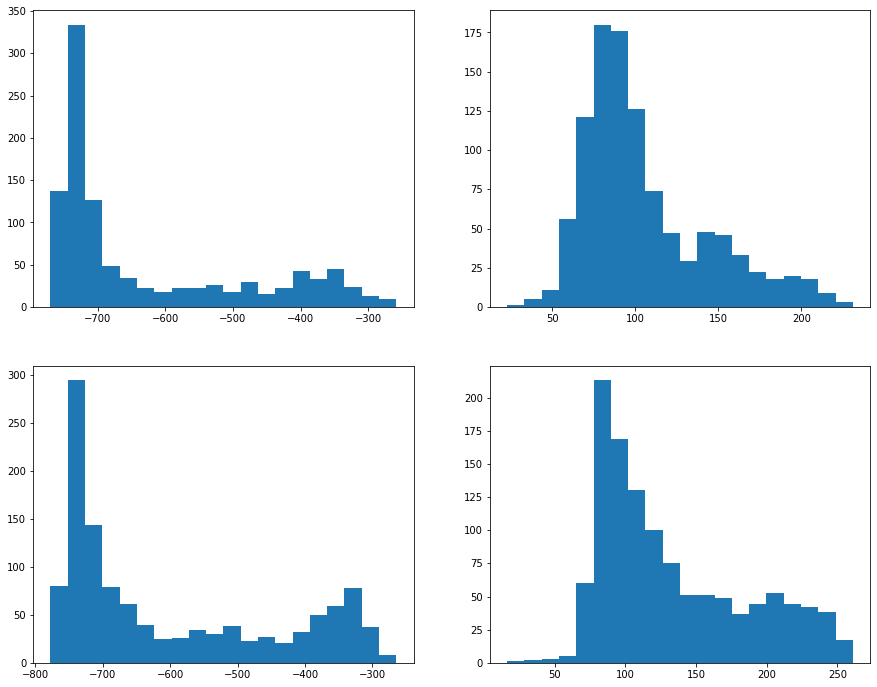

In [11]:
# Define a function that convert a list of lists in a global list
def flat_list(l):
    return [item for sublist in l for item in sublist]

# Flattening
mfcc1_d8_flat = flat_list(mfcc1_d8)
mfcc2_d8_flat = flat_list(mfcc2_d8)
mfcc1_d9_flat = flat_list(mfcc1_d9)
mfcc2_d9_flat = flat_list(mfcc2_d9)

# Plot the histograms
fig = plt.figure(figsize=(15,12))
fig.add_subplot(2, 2, 1)
plt.hist(mfcc1_d8_flat, bins=20)
fig.add_subplot(2, 2, 2)
plt.hist(mfcc2_d8_flat, bins=20)
fig.add_subplot(2, 2, 3)
plt.hist(mfcc1_d9_flat, bins=20)
fig.add_subplot(2, 2, 4)
plt.hist(mfcc2_d9_flat, bins=20)
plt.show()

The divergence between 8 and 9 is small in both featured. In order to classify them, we need more MFCC features.

Choose two recordings for each digit from two different speaker and compute Mel Filterbank Spectral Coefficients (MFSCs). Then, plot the correlation of the MFSCs and MFCCs for each recording.

In [12]:
spk1 = 1
spk2 = 2
n1 = 8
n2 = 9
for i in range(n_samples):
    if speaker[i] == spk1 and digit[i] == n1:
        s1_n1 = i
    if speaker[i] == spk1 and digit[i] == n2:
        s1_n2 = i
    if speaker[i] == spk2 and digit[i] == n1:
        s2_n1 = i
    if speaker[i] == spk2 and digit[i] == n2:
        s2_n2 = i
print("Speaker 1 - Digit 8: " + str(s1_n1))
print("Speaker 1 - Digit 9: " + str(s1_n2))
print("Speaker 2 - Digit 8: " + str(s2_n1))
print("Speaker 2 - Digit 9: " + str(s2_n2))

Speaker 1 - Digit 8: 12
Speaker 1 - Digit 9: 37
Speaker 2 - Digit 8: 109
Speaker 2 - Digit 9: 8


In [13]:
mfscs_1_1 = l.feature.melspectrogram(wav[s1_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_1_2 = l.feature.melspectrogram(wav[s1_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_2_1 = l.feature.melspectrogram(wav[s2_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfscs_2_2 = l.feature.melspectrogram(wav[s2_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)

In order to construct the correlation plot easily, we convert out data in a dataframe and use the function df.corr by pandas.

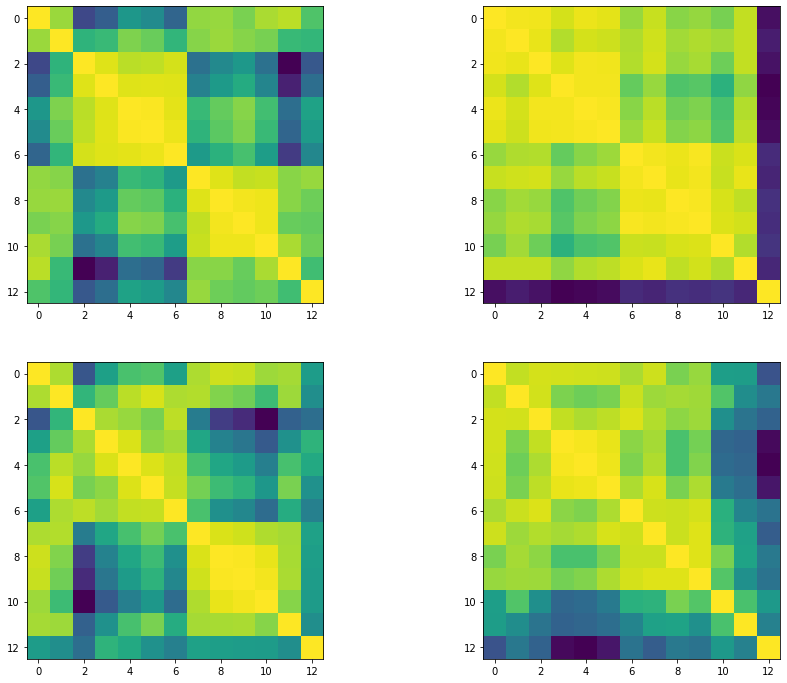

In [14]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2, 2, 1)
mfsc_df_1_1 = pd.DataFrame.from_records(mfscs_1_1.T)
plt.imshow(mfsc_df_1_1.corr())

fig.add_subplot(2, 2, 2)
mfsc_df_1_2 = pd.DataFrame.from_records(mfscs_1_2.T)
plt.imshow(mfsc_df_1_2.corr())

fig.add_subplot(2, 2, 3)
mfsc_df_2_1 = pd.DataFrame.from_records(mfscs_2_1.T)
plt.imshow(mfsc_df_2_1.corr())


fig.add_subplot(2, 2, 4)
mfsc_df_2_2 = pd.DataFrame.from_records(mfscs_2_2.T)
plt.imshow(mfsc_df_2_2.corr())

plt.show()


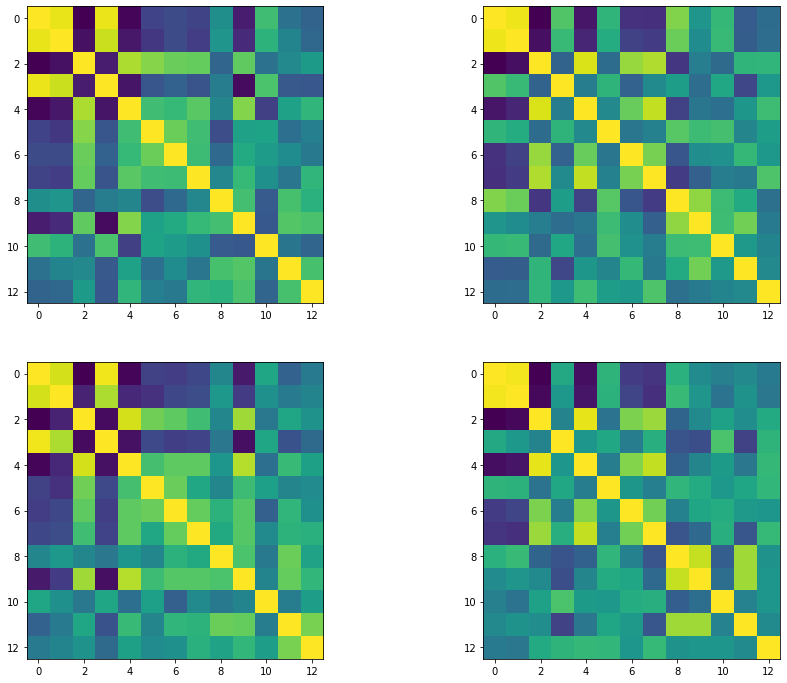

In [15]:
fig = plt.figure(figsize=(15,12))

fig.add_subplot(2, 2, 1)
mfcc_df_1_1 = pd.DataFrame.from_records(mfccs[s1_n1].T)
plt.imshow(mfcc_df_1_1.corr())

fig.add_subplot(2, 2, 2)
mfcc_df_1_2 = pd.DataFrame.from_records(mfccs[s1_n2].T)
plt.imshow(mfcc_df_1_2.corr())

fig.add_subplot(2, 2, 3)
mfcc_df_2_1 = pd.DataFrame.from_records(mfccs[s2_n1].T)
plt.imshow(mfcc_df_2_1.corr())

fig.add_subplot(2, 2, 4)
mfcc_df_2_2 = pd.DataFrame.from_records(mfccs[s2_n2].T)
plt.imshow(mfcc_df_2_2.corr())

plt.show()

We observe that MFSCs coefficients are higly correlated, while MSCCs are not. This explains the fact that the Discrete Cosine Transform (DCT) is used to decorrelate the mel filter bank coefficients, a process also referred to as whitening.

__Step 5:__ Extraction of a global feature vector for each recording, by combining the mean value and the variance of the mfccs – deltas – delta-deltas for all the windows.

In [16]:
# X = mean mffc  - mean delta - mean delta-deltas- var mfcc - var delta - var delta-deltas 
X = np.zeros((n_samples, 78))

for i in range(n_samples):
    X[i, :13] = np.mean(mfccs[i], axis=1)
    X[i, 13:26] = np.mean(delta[i], axis=1)
    X[i, 26:39] = np.mean(delta_deltas[i], axis=1)
    X[i, 39:52] = np.std(mfccs[i], axis=1)
    X[i, 52:65] = np.std(delta[i], axis=1)
    X[i, 65:] = np.std(delta_deltas[i], axis=1)


Plot the first two dimensions in a 2D scatter plot.

In [17]:
# Define a function that plots the decision surface of 2D-dimensional data
def scatter_2d(X, y, labels):
    fig, ax = plt.subplots()
    # title for the plots
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    
    one = ax.scatter(
        X0[y == 1], X1[y == 1],
        c='red', label=labels[0], 
        s=50, alpha=0.9, edgecolors='k')
    
    two = ax.scatter(
        X0[y == 2], X1[y == 2],
        c='purple', label=labels[1], 
        s=50, alpha=0.9, edgecolors='k')
    
    three = ax.scatter(
        X0[y == 3], X1[y == 3],
        c='green', label=labels[2],
        s=50, alpha=0.9, edgecolors='k')
    
    four = ax.scatter(
        X0[y == 4], X1[y == 4],
        c='gray', label=labels[3], 
        s=50, alpha=0.9, edgecolors='k')
    
    five = ax.scatter(
        X0[y == 5], X1[y == 5],
        c='orange', label=labels[4], 
        s=50, alpha=0.9, edgecolors='k')
    
    six = ax.scatter(
        X0[y == 6], X1[y == 6],
        c='black', label=labels[5],
        s=50, alpha=0.9, edgecolors='k')
    
    seven = ax.scatter(
        X0[y == 7], X1[y == 7],
        c='pink', label=labels[6], 
        s=50, alpha=0.9, edgecolors='k')
    
    eight = ax.scatter(
        X0[y == 8], X1[y == 8],
        c='white', label=labels[7], 
        s=50, alpha=0.9, edgecolors='k')
    
    nine = ax.scatter(
        X0[y == 9], X1[y == 9],
        c='yellow', label=labels[8],
        s=50, alpha=0.9, edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

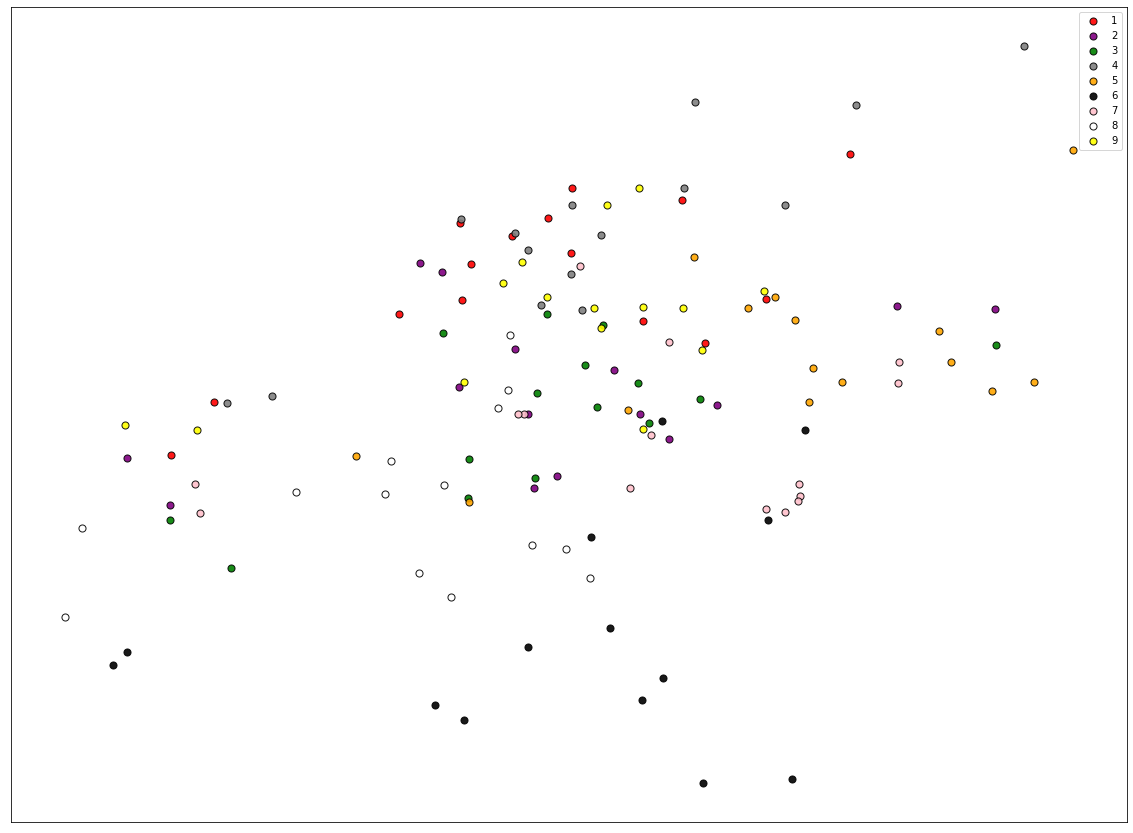

In [18]:
plt.rcParams['figure.figsize'] = [20, 15]
scatter_2d(X, digit, [i for i in range(1,10)])

We observe that if we take into account only the first two dimensions of the global feature vector, the points of the same class are not always close to each other and their class is easily separable among the other classes. As a result, a classifier would perform poorly in these 2D data.

__Step 6:__ Apply PCA to reduce the dimensions of the feature vector from 78 to 2 or 3 and plot the data in 2D and 3D respectively.

In [19]:
# Define PCA
pca_2d = PCA(n_components=2)
# Apply PCA on data
X_2d = pca_2d.fit_transform(X)

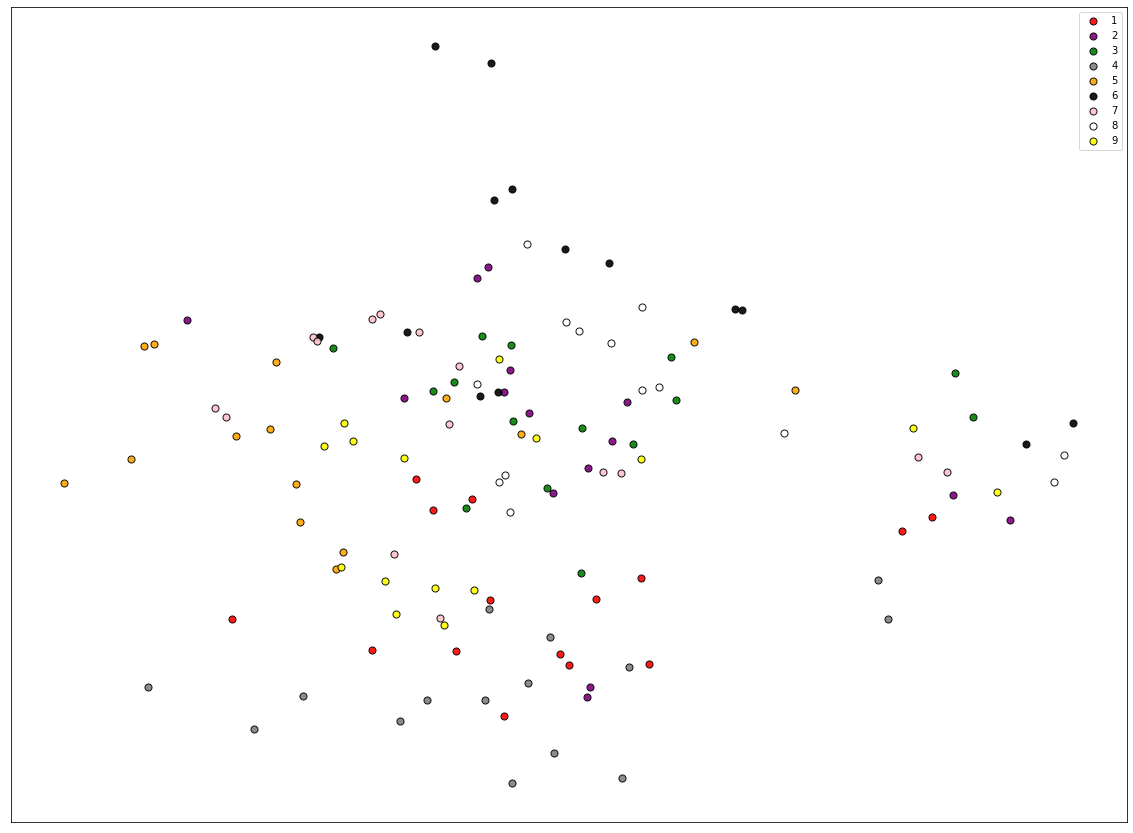

In [20]:
scatter_2d(X_2d, digit, [i for i in range(1, 10)])

After applying PCA, the scatter plot is much better since we kept more information from all the 78 dimensions in our 2D data.

In [21]:
# Define a function that plots the decision surface of 3-dimensional data
def scatter_3d(X, y, labels):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111, projection='3d')
    # title for the plots
    # Set-up grid for plotting.
    X0, X1, X2 = X[:, 0], X[:, 1], X[:,2]
    
    one = ax.scatter(
        X0[y == 1], X1[y == 1], X2[y == 1],
        c='red', label=labels[0],
        s=50, alpha=0.9, edgecolors='k')

    two = ax.scatter(
        X0[y == 2], X1[y == 2], X2[y == 2],
        c='purple', label=labels[1], 
        s=50, alpha=0.9, edgecolors='k')
    
    three = ax.scatter(
        X0[y == 3], X1[y == 3], X2[y == 3],
        c='green', label=labels[2],
        s=50, alpha=0.9, edgecolors='k')
    
    four = ax.scatter(
        X0[y == 4], X1[y == 4], X2[y == 4],
        c='gray', label=labels[3], 
        s=50, alpha=0.9, edgecolors='k')
    
    five = ax.scatter(
        X0[y == 5], X1[y == 5], X2[y == 5],
        c='orange', label=labels[4], 
        s=50, alpha=0.9, edgecolors='k')
    
    six = ax.scatter(
        X0[y == 6], X1[y == 6], X2[y == 6],
        c='black', label=labels[5],
        s=50, alpha=0.9, edgecolors='k')
    
    seven = ax.scatter(
        X0[y == 7], X1[y == 7], X2[y == 7],
        c='pink', label=labels[6], 
        s=50, alpha=0.9, edgecolors='k')
    
    eight = ax.scatter(
        X0[y == 8], X1[y == 8], X2[y == 8],
        c='white', label=labels[7], 
        s=50, alpha=0.9, edgecolors='k')
    
    nine = ax.scatter(
        X0[y == 9], X1[y == 9], X2[y == 9],
        c='yellow', label=labels[8],
        s=50, alpha=0.9, edgecolors='k')
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

In [22]:
# Define PCA
pca_3d = PCA(n_components=3)
# Apply PCA on data
X_3d = pca_3d.fit_transform(X)

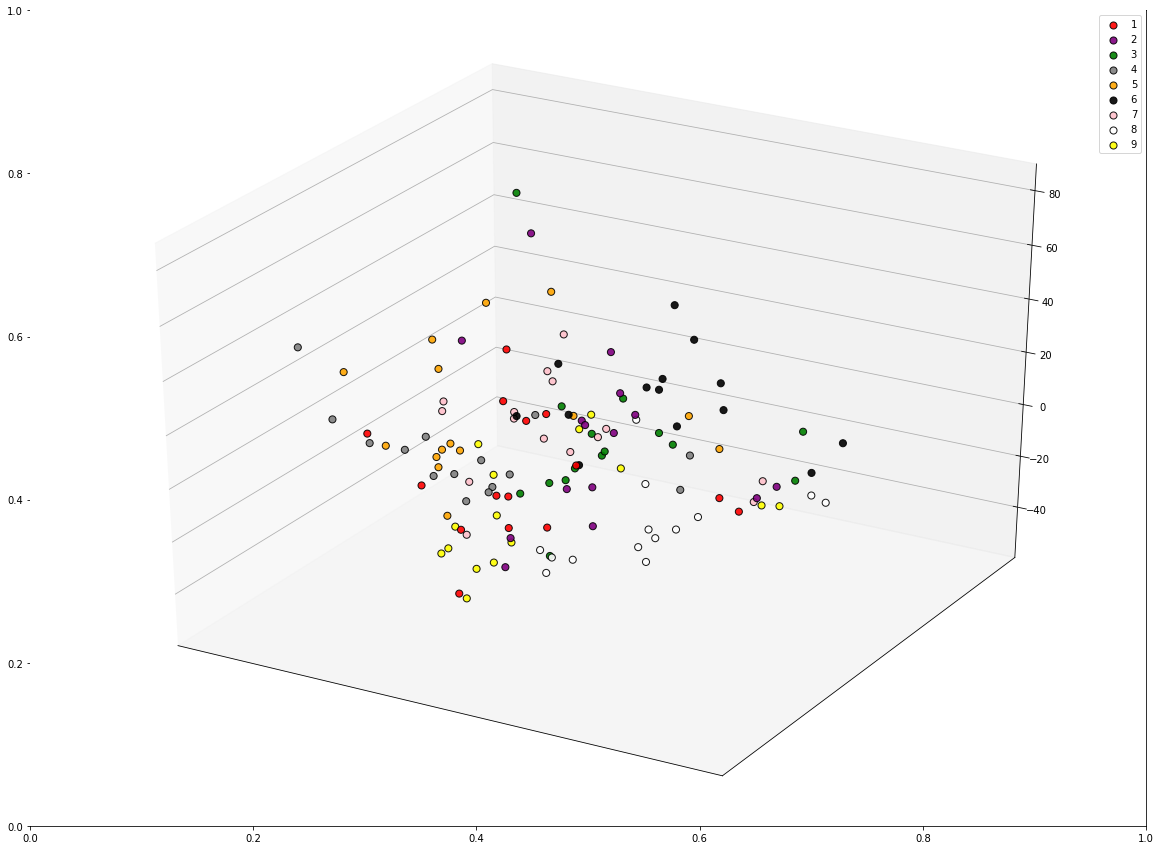

In [23]:
scatter_3d(X_3d, digit, [i for i in range(1,10)])

In [24]:
print(pca_2d.explained_variance_ratio_)
print(pca_3d.explained_variance_ratio_)

[0.58803289 0.11856749]
[0.58803289 0.11856749 0.10831836]


We observe that after dimensionality reduction we lost a lot of variance, that means that the whole procedure did not go well and we have lost useful information.

__Step 7:__ Classification

- Split data in train and test set in proportion 70%-30%

In [25]:
y = digit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

- Normalize our data

In [26]:
X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

- Define the numpy based Gaussian classifier used in the 1st Lab.

In [27]:
class GaussianNB_np(BaseEstimator, ClassifierMixin):  
    """Classify samples based on the Gaussian Naive Bayes"""

    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.prior = None
        self.classes = None
        self.n_classes = None


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        
        Calculates self.X_mean_ and self.X_var_ based on the mean 
        feature values in X for each class. Also, calculates self.prior
        that contains the prior probability of each class.
        
        self.X_mean_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.X_var_ becomes a numpy.ndarray of shape 
        (n_classes, n_features)
        
        self.prior becomes a numpy.array of shape 
        (n_classes)
        
        fit always returns self.
        """

        # Initialize useful variables
        self.classes = np.unique(y)
        train_size, n_features = X.shape
        self.n_classes = len(self.classes)
        self.X_mean_ = np.zeros((self.n_classes, n_features))
        self.X_var_ = np.zeros((self.n_classes, n_features))

        # Compute mean and variance values for each class
        for k, c in enumerate(self.classes):
            idx_i = [i for i in range(train_size) if y[i] == c]
            X_k = np.take(X, idx_i, axis=0)
            self.X_mean_[k, :] = np.mean(X_k, axis=0, keepdims=True)
            self.X_var_[k, :] = np.var(X_k, axis=0, keepdims=True)
        
        # Compute prior probabilities for each class
        self.prior = np.zeros(self.n_classes)
        for k, c in enumerate(self.classes):
            self.prior[k] = np.count_nonzero(y == c) / train_size
        return self
        

    def predict(self, X, smooth=None):
        """
        Make predictions for X based on
        the highest posterior probability
        """

        # Compute likelihood
        like = np.zeros((self.n_classes, len(X)))
        # Define e for calculation stability (division by zero).
        if smooth:
            e = smooth
        else:
            e = 10**(-9)
        for i in range(self.n_classes):
            like[i] = np.prod(1/(np.sqrt(2*np.pi*self.X_var_[i]+ e)) * \
                              np.exp(-0.5*((X - self.X_mean_[i])**2 / (self.X_var_[i] + e))), axis=1)

        return np.argmax(like.T * self.prior, axis=1) + 1
    
    def score(self, X, y, smooth=None):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        corr = 0
        y_pred = self.predict(X, smooth)
        corr = sum(int(y[i] == y_pred[i]) for i in range(len(y)))
        acc = corr / len(y)
        return acc

- Classify data using our custom Bayes from Lab 1.

In [28]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier 
gaussNB_np = GaussianNB_np()
gaussNB_np.fit(X_train, y_train)

print("Accuracy of custom NumPy GaussianNB classifier")
print()

# Predict using default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np.score(X_test, y_test, smooth=1)))


Accuracy of custom NumPy GaussianNB classifier

Smoothing 1e-9: 0.65
Smoothing 1e-6: 0.65
Smoothing 1e-3: 0.65
Smoothing 1: 0.7


In [29]:
# Define a custom scorer
def my_scorer(clf, X, y_true):
    return clf.score(X, y_true)

# Define the classifier 
gaussNB_np = GaussianNB_np()
gaussNB_np.fit(X_train_norm, y_train)

print("Accuracy of custom NumPy GaussianNB classifier  in normalized data")
print()

# Predict using default smoothing.
print("Smoothing 1e-9: " + str(gaussNB_np.score(X_test_norm, y_test)))

# Predict using 1e-6 smoothing.
print("Smoothing 1e-6: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=10**(-6))))

# Predict using 1e-3 smoothing.
print("Smoothing 1e-3: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=10**(-3))))

# Predict using 1 smoothing.
print("Smoothing 1: " + str(gaussNB_np.score(X_test_norm, y_test, smooth=1)))


Accuracy of custom NumPy GaussianNB classifier  in normalized data

Smoothing 1e-9: 0.6
Smoothing 1e-6: 0.675
Smoothing 1e-3: 0.45
Smoothing 1: 0.15


- Classify data using Naive Bayes of sklearn.

In [30]:
gaussNB = GaussianNB()

gaussNB.fit(X_train, y_train)

print("Accuracy of sklearn GaussianNB classifier")
print()

print(gaussNB.score(X_test, y_test))

Accuracy of sklearn GaussianNB classifier

0.65


In [31]:
gaussNB = GaussianNB()

gaussNB.fit(X_train_norm, y_train)

print("Accuracy of sklearn GaussianNB classifier in normalized data")
print()

print(gaussNB.score(X_test_norm, y_test))

Accuracy of sklearn GaussianNB classifier in normalized data

0.6


- Classify data using Nearest Neighbors classifier

In [32]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

print("Accuracy of Nearest Neihbors classifier")
print()

print(neigh.score(X_test, y_test))

Accuracy of Nearest Neihbors classifier

0.625


In [33]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_norm, y_train)

print("Accuracy of Nearest Neihbors classifier in normalized data")
print()

print(neigh.score(X_test_norm, y_test))

Accuracy of Nearest Neihbors classifier in normalized data

0.55


- Classify data using SVM classifier with linear kernel.

In [34]:
svm_linear = SVC(kernel="linear", probability=True) 
svm_linear.fit(X_train, y_train)

print("Accuracy of SVM classifier, using linear kernel")
print()

print(svm_linear.score(X_test, y_test))

Accuracy of SVM classifier, using linear kernel

0.875


In [35]:
svm_linear = SVC(kernel="linear", probability=True) 
svm_linear.fit(X_train_norm, y_train)

print("Accuracy of SVM classifier, using linear kernel in normalized data")
print()

print(svm_linear.score(X_test_norm, y_test))

Accuracy of SVM classifier, using linear kernel in normalized data

0.25


- Classify data using SVM classifier with poly kernel.

In [36]:
svm_poly = SVC(kernel="poly", probability=True) 
svm_poly.fit(X_train, y_train)

print("Accuracy of SVM classifier, using poly kernel")
print()

print(svm_poly.score(X_test, y_test))

Accuracy of SVM classifier, using poly kernel

0.85


In [37]:
svm_poly = SVC(kernel="poly", probability=True) 
svm_poly.fit(X_train_norm, y_train)

print("Accuracy of SVM classifier, using poly kernel in normalized data")
print()

print(svm_poly.score(X_test_norm, y_test))

Accuracy of SVM classifier, using poly kernel in normalized data

0.25


- Classify data using Logistic Regression.

In [38]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print("Accuracy of Logistic Regression classifier")
print()

print(log_reg.score(X_test, y_test))

Accuracy of Logistic Regression classifier

0.825


In [39]:
log_reg = LogisticRegression()
log_reg.fit(X_train_norm, y_train)

print("Accuracy of Logistic Regression classifier in normalized data")
print()

print(log_reg.score(X_test_norm, y_test))

Accuracy of Logistic Regression classifier in normalized data

0.25


- Summarize our results in the following table:

|    Classifier    |   Parameter     | Normalized | Accuracy |
| ---------------- | --------------- | ---------- | -------- |
|    Bayes_np      |  smooth=1e-6    |    No      |    65    |
|    Bayes_np      |  smooth=1e-6    |    Yes     |    67.5  |
|  Bayes_sklearn   |  smooth=1e-9    |    No      |    65    |
|  Bayes_sklearn   |  smooth=1e-9    |    Yes     |    60    |
| Nearest Neighbor |      n = 3      |    No      |    62.5  |
| Nearest Neighbor |      n = 3      |    Yes     |    55    |
|      SVM         | kernel = linear |    No      |    87.5  |
|      SVM         | kernel = linear |    Yes     |    25    |
|      SVM         | kernel = poly   |    No      |    85    |
|      SVM         | kernel = poly   |    Yes     |    25    |
|      Logistic    |        -        |    No      |    82.5  |
|      Logistic    |        -        |    Yes     |    25    |

__Step 8:__ Pytorch introduction

- Generate 10-point sin and cosine waves with f = 40 Hz and random amplitude.

In [40]:
f = 40
step = 0.001
X = np.zeros((1000, 10))
y = np.zeros((1000, 10))

for i in range(1000):
    # Random amplitude in range [0, 10]
    A = np.random.rand()*10
    # Random starting point in range [0, 40T]
    start = np.random.rand() * (40/f)
    time = np.linspace(start, start+step*10, num=10)
    X[i] = A*np.sin(2*np.pi*f*time)
    y[i] =  A*np.cos(2*np.pi*f*time)
    


- Plot some samples from our generated dataset

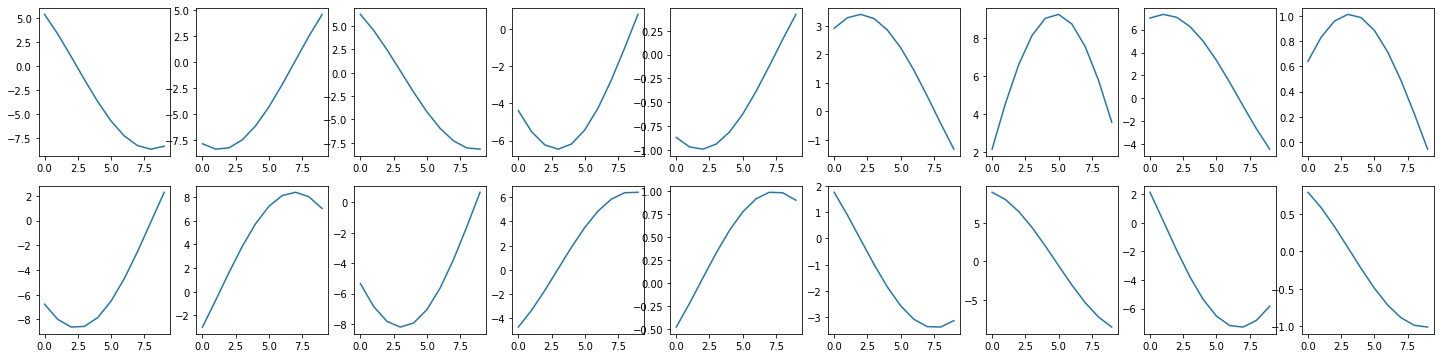

In [41]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(25,6))
columns = 9

samples = [100, 200, 300, 400, 500, 600, 700, 800, 900]

for i in range(9):
    # Display the randomly selected image in a subplot
    fig.add_subplot(2, columns, i+1)
    plt.plot(np.arange(10), X[samples[i]])

for i in range(9):
    # Display the randomly selected image in a subplot
    fig.add_subplot(2, columns, i+10)
    plt.plot(np.arange(10), y[samples[i]])

    
plt.show()

- Split data in train and test set and convert them in tensors.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

- Define an LSTM

In [43]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTMCell(1, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.hidden_layer_size, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

- Define model parameters

In [46]:
model = LSTMNet().double()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

- Train the model

In [47]:
train_losses = []
test_losses = []

epochs = 1500
for i in range(epochs):
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    if i%100 == 0:
        print('Train loss', loss.item())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        pred = model(X_test)
        loss = criterion(pred, y_test)
        if i%100 == 0:
            print('Test loss:', loss.item())
            print()
        test_losses.append(loss.item())

Train loss 17.41997169641994
Test loss: 16.608798204726675

Train loss 6.650810449001553
Test loss: 6.435939685171022

Train loss 3.6809376031988816
Test loss: 3.542381897473431

Train loss 2.613421079439099
Test loss: 2.531779299806002

Train loss 2.1950735768923995
Test loss: 2.154782719251485

Train loss 2.0027063628260677
Test loss: 1.9799479335201546

Train loss 1.9024939185701746
Test loss: 1.8799880491087446

Train loss 1.8524631878077946
Test loss: 1.8224162962039878

Train loss 1.8265387023423698
Test loss: 1.7858492676616942

Train loss 1.8125039909687424
Test loss: 1.7617113604218195

Train loss 1.804270710302491
Test loss: 1.7448105364387285

Train loss 1.7987375181703738
Test loss: 1.7319123010945474

Train loss 1.794942749377739
Test loss: 1.7223173283196498

Train loss 1.7920821849033668
Test loss: 1.7148203295704016

Train loss 1.7930014390667843
Test loss: 1.711550704214112



In [49]:
train_losses

[17.41997169641994,
 17.292511849932414,
 17.16700766969719,
 17.042487502273644,
 16.917910110553358,
 16.792162505229594,
 16.664008504524134,
 16.532099222443588,
 16.39500173458446,
 16.251191556970177,
 16.099037029621538,
 15.936819027949857,
 15.762781545322532,
 15.575190698536412,
 15.372390565823311,
 15.152861215804997,
 14.915291086585354,
 14.658679368876655,
 14.382483131387726,
 14.086813253405815,
 13.772668084826154,
 13.44217814873913,
 13.09881575381309,
 12.747501050597059,
 12.394537251126618,
 12.0473207207525,
 11.713760067839615,
 11.401401635629357,
 11.116421615328997,
 10.862733611235601,
 10.641465927312325,
 10.451073272502576,
 10.288077940952062,
 10.148088970740785,
 10.026739877311773,
 9.92038910270006,
 9.82658770434181,
 9.74423143894398,
 9.673198853245637,
 9.613460332370378,
 9.564073580681898,
 9.522665245312668,
 9.485651860705138,
 9.44894577539594,
 9.408745821113593,
 9.362147114140663,
 9.30744854792252,
 9.2441775497639,
 9.172928432432728,

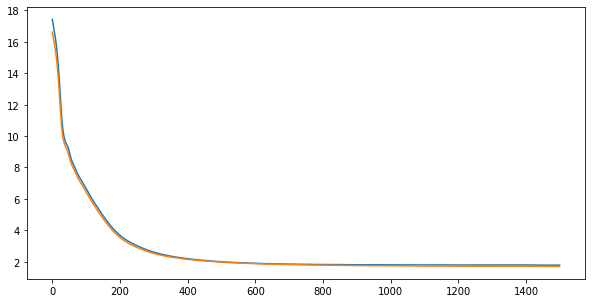

In [54]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.arange(len(train_losses)), train_losses)
plt.plot(np.arange(len(test_losses)), test_losses)

- Plot some test predictions

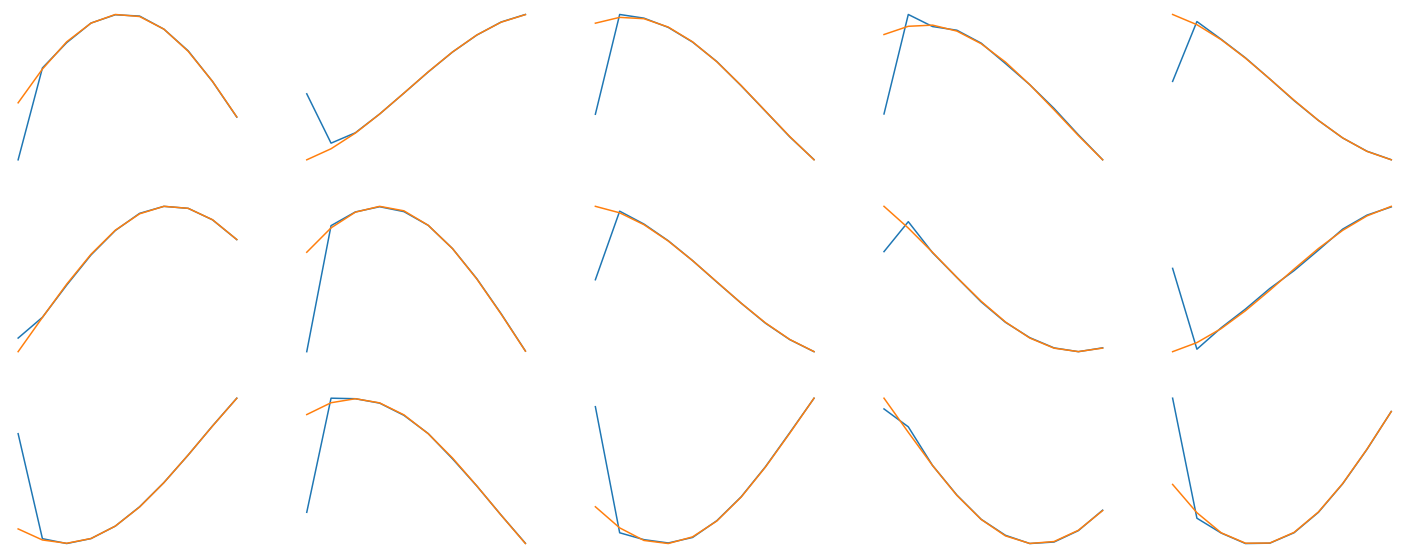

In [55]:
# Define a figure with 10 plots.
fig = plt.figure(figsize=(25,10))
columns = 5
rows = 3

samples = np.random.randint(0, 200, 15)

for i in range(15):
    # Display the randomly selected image in a subplot
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    with torch.no_grad():
        pred = model(X_test[samples[i]].view(1,-1))
    plt.plot(np.arange(10), pred[0])
    plt.plot(np.arange(10), y_test[samples[i]])
    


We observe that the cosine prediction is very successful. The only point that is not predicted properly is the first, because the model has not enough data at this time.